In [1]:
typealias Float Float32
@show(Float)

using JLD

Float = Float32


In [2]:
cd("/home/siva/towards_MERA/mera/")
include("IsingHam.jl")
include("BinaryMERA.jl")
include("OptimizeMERA.jl")

isingH, Dmax = build_H_Ising();

In [3]:
const CHI               = 5;
const LAYER_SHAPE       = (8,fill(CHI,7)...);
const INIT_LAYERS       = 3;
const INIT_LAYER_SHAPE  = LAYER_SHAPE[1:(INIT_LAYERS+1)];

In [4]:
m = generate_random_MERA(INIT_LAYER_SHAPE);

In [5]:
parameters_initialize = Dict(:EnergyDelta => 2.0^(-33)  , :Qsweep => 1 ,  :Qbatch => 2, :Qlayer => 2, :Qsingle => 2);
parameters_test = Dict(:EnergyDelta => 2.0^(-33)  , :Qsweep => 2 ,  :Qbatch => 10, :Qlayer => 3, :Qsingle => 3);

In [6]:
@time improveGraft!(isingH, m, parameters_initialize);

   2 iter: E = -0.36366105080 , rate of change = 5.8e-01 , fractional error = 7.1e-01
----------------------------
 14.859565 seconds (10.44 M allocations: 4.085 GB, 2.20% gc time)


In [7]:
@time improveGraft!(isingH, m, parameters_test);

  10 iter: E = -1.23646676540 , rate of change = 1.5e-02 , fractional error = 2.9e-02
  20 iter: E = -1.27193725109 , rate of change = 2.8e-04 , fractional error = 1.1e-03
----------------------------
103.524939 seconds (40.16 M allocations: 79.314 GB, 4.53% gc time)


### @time measurements of improveGraft!()
- Float64
>219.612873 seconds (40.17 M allocations: 156.714 GB, 4.09% gc time)
- Float32: 
>103.524939 seconds (40.16 M allocations: 79.314 GB, 4.53% gc time)

In [8]:
using ProfileView
Profile.init(;n=10^7,delay=0.001)

In [9]:
Profile.clear()
@profile improveGraft!(isingH, m, parameters_test);

  10 iter: E = -1.27297842503 , rate of change = 3.4e-05 , fractional error = 2.8e-04
  20 iter: E = -1.27310764790 , rate of change = 2.2e-06 , fractional error = 1.8e-04
----------------------------


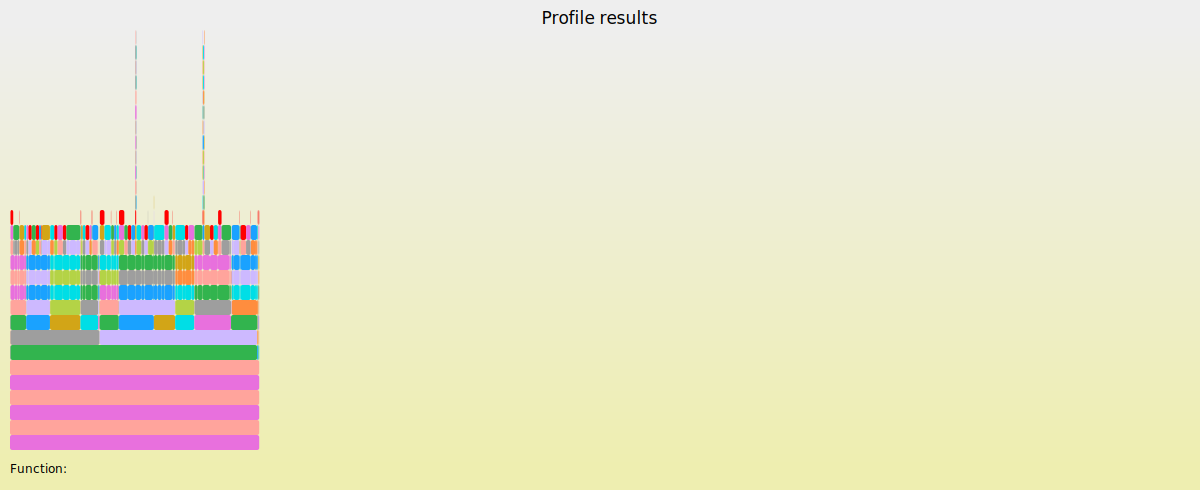

In [10]:
ProfileView.view()

### Conclusion
Memory allocations for `rhoslist_snapshot` don't seem to be hurting us; at least for small number of sweeps.

# Profiling including the file writes

In [13]:
# to ensure functions compiled
function runfunc(m, isingH, parameters)
    jldopen("testfile.jld","w") do file
        rhoslist_snapshot = improveGraft!(isingH, m, parameters_test)
        write(file, "rhoslist_snapshots", rhoslist_snapshot)
    end
end

runfunc (generic function with 2 methods)

In [15]:
@time runfunc(m, isingH, parameters_initialize);

  10 iter: E = -1.27314269543 , rate of change = 1.9e-06 , fractional error = 1.6e-04
  20 iter: E = -1.27315485477 , rate of change = 2.4e-06 , fractional error = 1.5e-04
----------------------------
121.851544 seconds (42.86 M allocations: 79.430 GB, 5.10% gc time)


In [17]:
@time runfunc(m, isingH, parameters_test);

  10 iter: E = -1.27317249775 , rate of change = 2.4e-06 , fractional error = 1.3e-04
  20 iter: E = -1.27317464352 , rate of change = 5.7e-06 , fractional error = 1.3e-04
----------------------------
103.385939 seconds (40.56 M allocations: 79.331 GB, 5.76% gc time)


### @time measurements of runfinc()
Memory allocation and processing time seems to be the same as improveGraft!(), so maybe the writing to file is not a significant bottleneck?
- Float32:
>103.385939 seconds (40.56 M allocations: 79.331 GB, 5.76% gc time)

In [19]:
Profile.clear()
@profile runfunc(m, isingH, parameters_test);
ProfileView.view()

  10 iter: E = -1.27317535877 , rate of change = 8.8e-06 , fractional error = 1.3e-04
  20 iter: E = -1.27317702770 , rate of change = 2.1e-06 , fractional error = 1.3e-04
----------------------------


LoadError: LoadError: UndefVarError: view not defined
while loading In[19], in expression starting on line 3

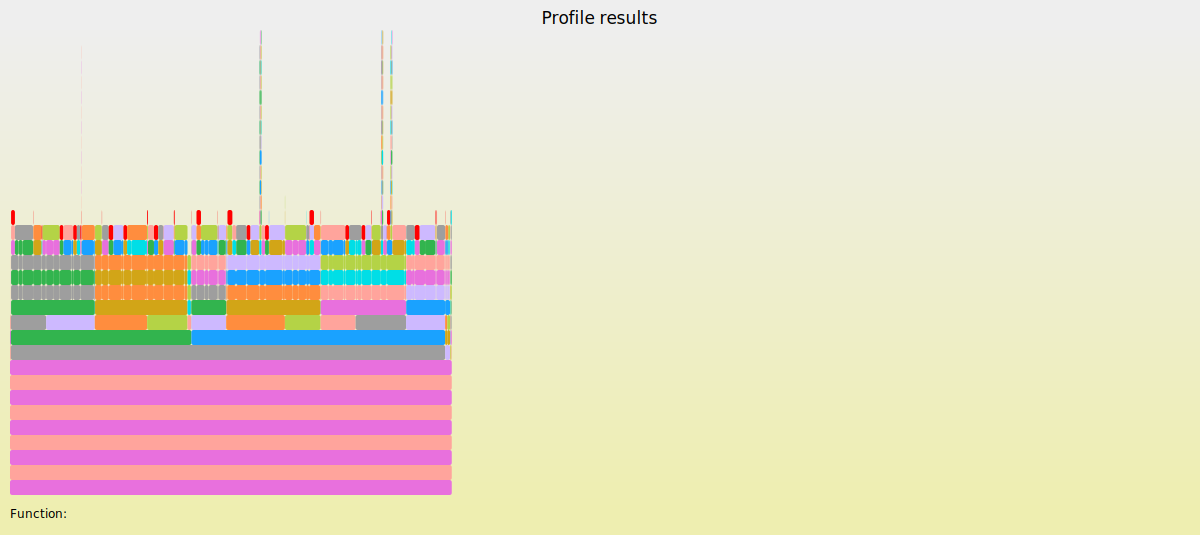

In [20]:
ProfileView.view()